![cenarios](modelos_abordagem.jpg)

### README

Para cada ponto proposto no desafio, eu separei uma seção neste notebook. No fim de cada seção há uma subseção 'conclusão' com respostas/comentários.

Iniciamos o notebook construindo o dataset a partir dos dados disponibilizados e depois respondemos as perguntas do desafio.

In [1]:
import pandas as pd
import numpy as np

In [2]:
submissao = pd.read_excel('data.xlsx', sheet_name=1)
submissao['data_hora'] = pd.to_datetime(submissao['Dia'].astype(str) + ' ' + submissao['Hora'].astype(str), format='%Y-%m-%d %H:%M:%S')
submissao = submissao.drop('CBK', axis=1)
submissao = submissao.sort_values(['data_hora'])

In [3]:
base = pd.read_excel('data.xlsx')
base['data_hora'] = pd.to_datetime(base['Dia'].astype(str) + ' ' + base['Hora'].astype(str), format='%Y-%m-%d %H:%M:%S')
base = base.sort_values(['data_hora'])
base['CBK'] = np.where(base.CBK == 'Não', 0, 1)

### Constrói Dataset

#### Add n_cbk_anteriores

Numero de transações sem chargeback desde o último cbk

In [4]:
def add_n_cbk_anteriores(df, aux, modo):
    def get_n_cbk_anteriores(series):
        series = list(series)
        ocorrencias = [0] * len(series)
        contador = 0

        for i in range(len(series)):
            if i==0:
                ocorrencias[i] = -1
            else:
                ocorrencias[i] = contador
            if series[i] == 1:
                contador += 1
        return(ocorrencias)    

    def transform(df):
        n_cbk_anteriores = []
        for cartao in df.Cartão:  
            if cartao in aux.Cartão.array:
                ocorrencias = aux[(aux.Cartão == cartao) & (aux.CBK == 1)]
                n_cbk_anteriores.append(len(ocorrencias))
                continue
            n_cbk_anteriores.append(-1)
        return(n_cbk_anteriores)
    
    df = df.sort_values(['Cartão','data_hora'])
    if modo == 'fit':
        n_cbk_anteriores = df.groupby('Cartão').CBK.apply(get_n_cbk_anteriores)
        df['n_cbk_anteriores'] = [st for row in n_cbk_anteriores for st in row]
    else:
        df['n_cbk_anteriores'] = transform(df)
        
    return(df)
    

#### Add n_pedidos_tempo

Indica quantas transações foram feitos no ultimo periodo de tempo

In [5]:
def add_n_transacoes_tempo(df, aux, modo, segundos_dif=3600):

    def get_n_transacoes_tempo(data_hora, segundos_dif): #1h = 3600segundos
        n_transacoes = []
        for idx, data_hora_atual in enumerate(data_hora):
            n_transacoes_tempo = 0
            for data_hora_anterior in data_hora[:idx]:
                if (data_hora_atual - data_hora_anterior).seconds < segundos_dif: 
                    n_transacoes_tempo+=1
            n_transacoes.append(n_transacoes_tempo)
        return(n_transacoes)
    
    def transform(df, aux):
        aux = pd.concat([df[['Cartão', 'data_hora']], aux[['Cartão', 'data_hora']]])
        n_transacoes = []
        for cartao, data_hora_atual in zip(df.Cartão, df.data_hora):  
            if cartao in aux.Cartão.array:
                ocorrencias = aux[(aux.Cartão == cartao)]
                print(ocorrencias)
                n_transacoes_tempo = -1 # comeca em -1 porque uma transacao sempre encontra ela mesma
                for data_hora_anterior in ocorrencias.data_hora:
                    if (data_hora_atual - data_hora_anterior).seconds < segundos_dif: 
                        n_transacoes_tempo+=1
                n_transacoes.append(n_transacoes_tempo)
                continue
            n_transacoes.append(0)
        return(n_transacoes)
        
    
    if modo == 'fit':
        n_transacoes_tempo = df.groupby('Cartão').data_hora.apply(lambda x: get_n_transacoes_tempo(x, segundos_dif))
        df = df.sort_values(['Cartão','data_hora'])
        df['n_transacoes_tempo'] = [st for row in n_transacoes_tempo for st in row]
    else:
        df['n_transacoes_tempo'] = transform(df, aux)
    return(df)

In [6]:
# devia ter sido feito com o scikit

def preprocess_data(df, aux, modo='fit'): #modo = fit ou transform para 
    df['hora_h'] = df.Hora.astype(str).str.slice(start=0, stop=2).astype(int)
    df['dia_sem'] = df.Dia.dt.dayofweek
    df['semana_mes'] = df.Dia.dt.isocalendar().week
    
    df = df.sort_values(['Cartão','data_hora'])
    
    df = add_n_cbk_anteriores(df, aux, modo)
    df['historico_cbk'] = np.where(df.n_cbk_anteriores >= 1, 1, df.n_cbk_anteriores)
    df = add_n_transacoes_tempo(df, aux, modo)
    
    
    # colocar numa funcao para padronizar
    if modo=='fit':
        data = df
    else:
        data = aux
    
    mediana_ncb = np.median(data[data.CBK == 0].Valor)
    mediana_cb = np.median(data[data.CBK == 1].Valor)

    df['dif_mediana_cliente_cb'] = df.Valor - mediana_cb
    df['dif_mediana_cliente_ncb'] = df.Valor - mediana_ncb
    
    lim = 400
    df['dif_valor_lim'] = df.Valor - lim
    
    return(df)

In [7]:
%%capture --no-display

base = preprocess_data(base, None, modo='fit')
submissao = preprocess_data(submissao, base, modo='transform')

### Qual o perfil transacional do cliente?

In [8]:
base.describe(include='all', datetime_is_numeric=True)

,Dia,Hora,Valor,Cartão,CBK,data_hora,hora_h,dia_sem,semana_mes,n_cbk_anteriores,historico_cbk,n_transacoes_tempo,dif_mediana_cliente_cb,dif_mediana_cliente_ncb,dif_valor_lim
count,11128,11128,11128.000000,11128,11128.000000,11128,11128.000000,11128.000000,11128.000000,11128.000000,11128.000000,11128.000000,11128.000000,11128.000000,11128.000000
unique,NaN,10044,NaN,9260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,16:03:01,NaN,552289******7788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2015-05-16 02:16:31.229331456,NaN,129.550076,NaN,0.051402,2015-05-16 18:06:43.237329152,15.338785,2.753505,20.334472,-0.703451,-0.795740,0.169752,-2.449924,30.550076,-270.449924
min,2015-05-01 00:00:00,NaN,1.000000,NaN,0.000000,2015-05-01 00:01:54,0.000000,0.000000,18.000000,-1.000000,-1.000000,0.000000,-131.000000,-98.000000,-399.000000
25%,2015-05-09 00:00:00,NaN,55.000000,NaN,0.000000,2015-05-09 19:16:07.500000,12.000000,1.000000,19.000000,-1.000000,-1.000000,0.000000,-77.000000,-44.000000,-345.000000
50%,2015-05-15 00:00:00,NaN,99.000000,NaN,0.000000,2015-05-15 11:03:19,16.000000,3.000000,20.000000,-1.000000,-1.000000,0.000000,-33.000000,0.000000,-301.000000
75%,2015-05-23 00:00:00,NaN,154.000000,NaN,0.000000,2015-05-23 21:04:15.750000128,19.000000,4.000000,21.000000,-1.000000,-1.000000,0.000000,22.000000,55.000000,-246.000000
max,2015-05-30 00:00:00,NaN,2920.000000,NaN,1.000000,2015-05-30 23:51:31,23.000000,6.000000,22.000000,19.000000,1.000000,19.000000,2788.000000,2821.000000,2520.000000


In [9]:
import sweetviz as sv
analyze_report = sv.analyze(base)
analyze_report.show_html('report.html', open_browser=False)

                                             |      | [  0%]   00:00 -> (? left)

Report report.html was generated.


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
def barplot_var(serie, top=None, normalize=True, sort_by='index', sort_asc=True):
    
    df = serie.value_counts(normalize=normalize).reset_index(name='counts').sort_values(sort_by, ascending=sort_asc)
    if top:
        df = df.head(top)
    sns.barplot(x='index', y='counts', data=df)
    pos, label = plt.xticks(rotation = 'vertical')

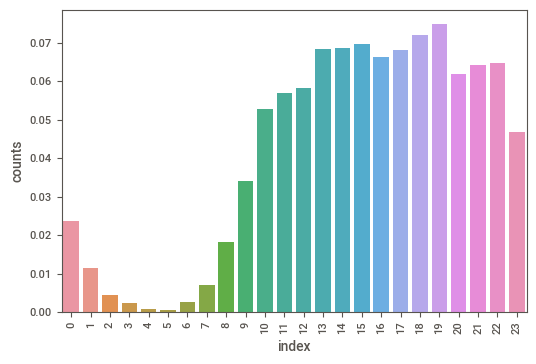

In [12]:
barplot_var(base.hora_h)

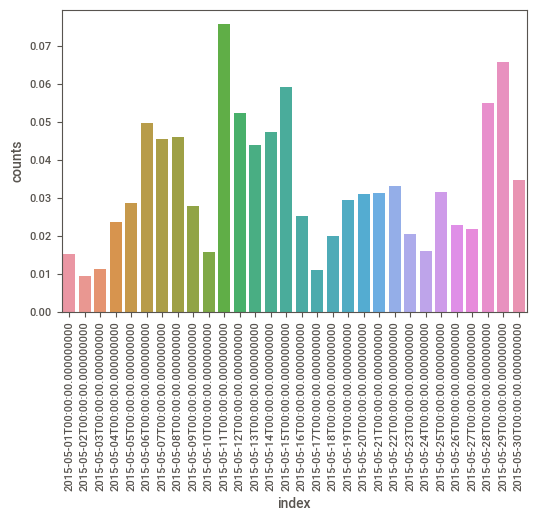

In [13]:
barplot_var(base.Dia)

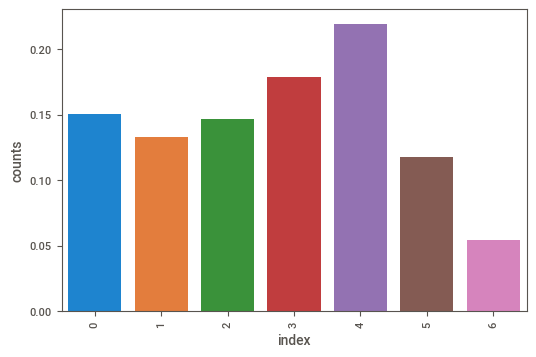

In [14]:
barplot_var(base.dia_sem)

<AxesSubplot:xlabel='Valor'>

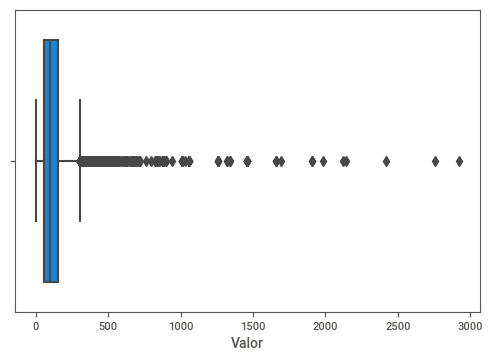

In [15]:
sns.boxplot(x='Valor', data=base)

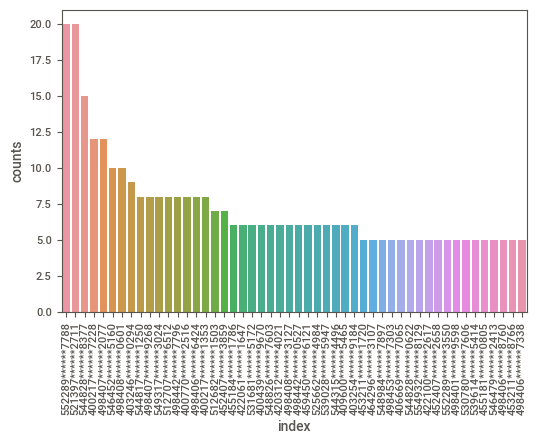

In [16]:
barplot_var(base['Cartão'], top=50, normalize=False, sort_by='counts', sort_asc=False)

1     7963
2     1004
3      184
4       50
5       27
6       14
8        8
20       2
12       2
10       2
7        2
15       1
9        1
Name: n_pagamentos, dtype: int64


<AxesSubplot:xlabel='n_pagamentos', ylabel='Count'>

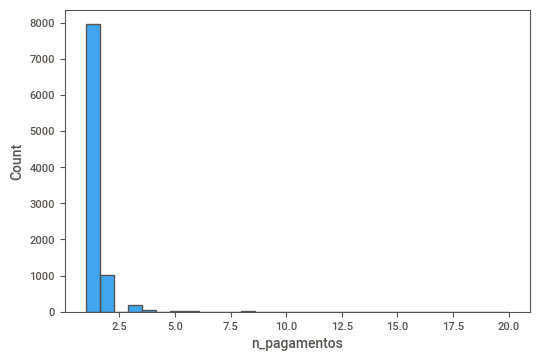

In [17]:
count_cartao = base['Cartão'].value_counts().reset_index(name='n_pagamentos')
print(count_cartao.n_pagamentos.value_counts())
sns.histplot(count_cartao, x='n_pagamentos', bins=30)

In [18]:
base.CBK.value_counts(normalize=True)

0    0.948598
1    0.051402
Name: CBK, dtype: float64

#### Características
* O cliente tem transações acontecendo 24h por dia, 7 dias por semana.
* As transações tem ticket médio de 130 reais, sendo metade das transações com valor de até 99 reais e 90% das transações tem valor de até 336 reais.
* 98.82% ((7963+1004+184)/9260) dos cartões usados para fazer transações, foram utilizados até 3 vezes no mes.

#### Conclusão
O cliente faz muitas transações com poucos cartões e poucas transações com muitos cartões diferentes, indicativo de alta rotatividade de cartões que fazem compra com ele. Devido o ticket médio de 130 reais, mediana de 99 reais e 90% das transações terem valor de até 336 reais, pode-se entender que o valor das transações não costumam ser altos.

* Sabendo que pode-se lucrar com transações altas ou com muitas transações de valor baixo e assumindo que o ticket médio de 130 reais é relativamente baixo, suponho que lucro dele deve vir principalmente da quantidade de transações que é feita.



### Qual o perfil das transações que retornaram chargeback?

In [19]:
from scipy import stats

#### Numero de CBK em transacoes que aconteceram mais de uma vez com o mesmo cartao

In [20]:
cbk_primeira_transacao = len(base[(base.CBK==1) & (base.n_cbk_anteriores == -1)])
cbk_outras = len(base[(base.CBK==1) & (base.n_cbk_anteriores != -1)])

print('CBK em primeira transacao: ' + str(cbk_primeira_transacao))
print('CBK em segunda ou posteriores transacoes: ' + str(cbk_outras))

CBK em primeira transacao: 179
CBK em segunda ou posteriores transacoes: 393


#### Valor de transações chargeback são maiores que não chargeback?

<AxesSubplot:xlabel='CBK', ylabel='Valor'>

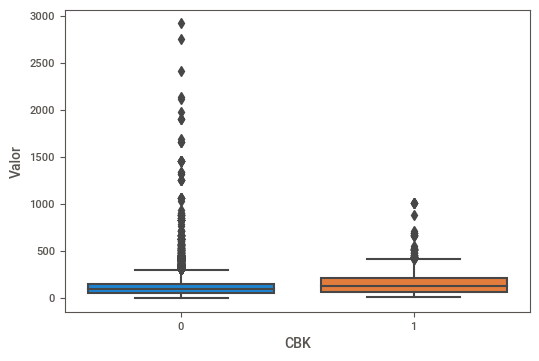

In [21]:
sns.boxplot(x='CBK', y='Valor', data=base)

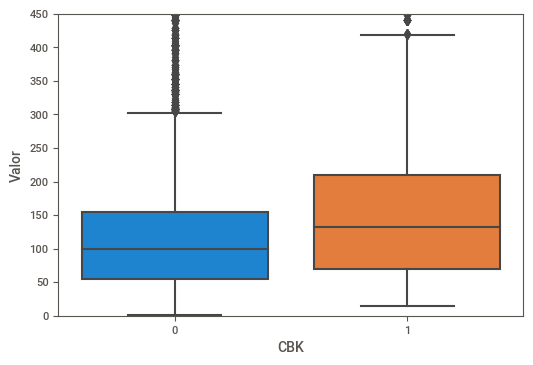

In [22]:
plot_valor_box = sns.boxplot(x='CBK', y='Valor', data=base)
plot_valor_box_lim = plot_valor_box.set(ylim=(0, 450))

In [23]:
# h0: dados sao normais
# h1: dados nao sao normais
def testa_normalidade(dados):
    w, p_valor = stats.shapiro(dados)
    if p_valor < 0.05:
        print("dados nao sao normais")
    else:
        print("dados seguem distribuicao normal")

In [24]:
testa_normalidade(base[base.CBK == 1].Valor)

dados nao sao normais


In [25]:
# h0: media_x <= media_y
# h1: media_x > media_y
u, p_valor = stats.mannwhitneyu(base[base.CBK == 1].Valor, base[base.CBK == 0].Valor, alternative="greater")
if p_valor < 0.05:
    print("H1: Media dos valores de chargeback é maior que a media dos não chargeback")
else:
    print("H0: Media dos valores de chargeback é menor ou igual à media dos não chargeback")

H1: Media dos valores de chargeback é maior que a media dos não chargeback


#### Distribuição de CBK por valor de transação

<AxesSubplot:xlabel='valor', ylabel='percent'>

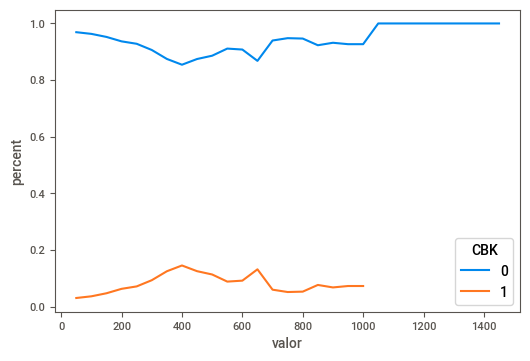

In [26]:
per_dists = []
for valor in range(50, 1500, 50):
    dist = base[['Cartão','Valor','CBK']].drop_duplicates()
    per_dist = dist[(dist.Valor >= valor)].CBK.value_counts(normalize=True).reset_index(name='percent').rename({'index':'CBK'}, axis=1)
    per_dist['valor'] = valor
    per_dists.append(per_dist)
per_dists = pd.concat(per_dists).reset_index(drop=True)

sns.lineplot(data=per_dists, x='valor', y='percent', hue='CBK')

#### Transações chargeback ocorrem mais vezes que não chargeback em 1h?

In [27]:
transacoes_1h = base.groupby(['Cartão','CBK']).n_transacoes_tempo.max().reset_index(name='n_transacoes_anterior_1h')
transacoes_1h = transacoes_1h.sort_values('n_transacoes_anterior_1h', ascending=False).reset_index(drop=True)
transacoes_1h

,Cartão,CBK,n_transacoes_anterior_1h
0,552289******7788,1,19
1,544828******8377,1,14
2,400217******7228,1,11
3,521397******2711,1,10
4,498408******0601,1,9
...,...,...,...
9271,470598******8025,0,0
9272,470598******7975,0,0
9273,470598******7812,0,0
9274,470598******7598,0,0


<AxesSubplot:xlabel='CBK', ylabel='n_transacoes_anterior_1h'>

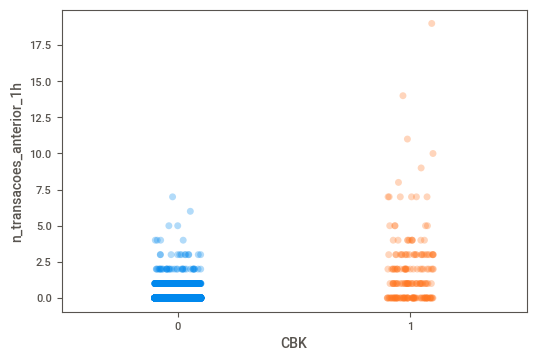

In [28]:
sns.stripplot(data=transacoes_1h, x='CBK', y='n_transacoes_anterior_1h', alpha=0.3)

### Transações com cartão que já teve CBK está mais propenso a ter CBK?

In [29]:
n_transacao_cartao = base['Cartão'].value_counts().reset_index(name='n_transacoes')
cartoes_multi_transacao = n_transacao_cartao[n_transacao_cartao.n_transacoes >= 2]['index']

transacoes_cartoes_2_mais_vezes = base[base.Cartão.isin(cartoes_multi_transacao) & (base.historico_cbk == 1)]
transacoes_cartoes_2_mais_vezes[['CBK','historico_cbk']].value_counts()

CBK  historico_cbk
1    1                387
0    1                 18
dtype: int64

#### Conclusão

Transações que retornam chargeback acontecem mais frequentemente em cartões que já tiveram alguma transação passada com CBK, em transações com o mesmo cartão que acontece repetidas vezes em um período curto de tempo (1h no exemplo) e geralmente tendem a ter valor mais alto que transações que não tem CBK.

### Previsão de Chargeback

In [30]:
base = base.sort_values('data_hora')
base.head()

,Dia,Hora,Valor,Cartão,CBK,data_hora,hora_h,dia_sem,semana_mes,n_cbk_anteriores,historico_cbk,n_transacoes_tempo,dif_mediana_cliente_cb,dif_mediana_cliente_ncb,dif_valor_lim
0,2015-05-01,00:01:54,36.54,536518******2108,0,2015-05-01 00:01:54,0,4,18,-1,-1,0,-95.46,-62.46,-363.46
1,2015-05-01,00:03:46,36.54,536518******2108,0,2015-05-01 00:03:46,0,4,18,0,0,1,-95.46,-62.46,-363.46
2,2015-05-01,00:08:50,69.00,453211******1239,0,2015-05-01 00:08:50,0,4,18,-1,-1,0,-63.00,-30.00,-331.00
3,2015-05-01,00:27:00,193.43,548827******1705,0,2015-05-01 00:27:00,0,4,18,-1,-1,0,61.43,94.43,-206.57
4,2015-05-01,01:32:46,132.00,531681******9778,0,2015-05-01 01:32:46,1,4,18,-1,-1,0,0.00,33.00,-268.00


In [31]:
clf_base = base.drop(['Dia','Hora','Cartão','data_hora', 'semana_mes', 'Valor'], axis=1)

In [32]:
# divisao temporal faz mais sentido para o problema
train_test_split = 0.67
idx_split = round(clf_base.shape[0]*train_test_split)
idx_split

train = clf_base.iloc[:idx_split]
test = clf_base.iloc[idx_split:]

In [33]:
y_train = train.CBK
X_train = train.drop('CBK', axis=1)

y_test = test.CBK
X_test = test.drop('CBK', axis=1)

In [34]:
# from sklearn.utils import sampling

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Define pipeline
clf = Pipeline([
    ('scaler', StandardScaler()),
    # ('oversample', None),
    ('clf', None)
])

# Define os parâmetros para GridSearch
params = [
    {
        'clf': [RandomForestClassifier()],
        'clf__n_estimators': [10, 50, 100],
        'clf__max_depth': [5, 10, 15],
        'clf__min_samples_split': [2, 5, 10],
        # 'oversample': [None, sampling.RandomOverSampler(), sampling.SMOTE()],
    },
    {
        'clf': [SVC()],
        'clf__C': [0.1, 1, 10], 
        'clf__kernel': ['linear', 'rbf'],
        # 'oversample': [None, sampling.RandomOverSampler(), sampling.SMOTE()],
    }
]


# Executa o GridSearch
grid_search = GridSearchCV(clf, params, cv=5, scoring='f1') # o scoring pode variar a depender do negocio
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', None)]),
             param_grid=[{'clf': [RandomForestClassifier(max_depth=5,
                                                         n_estimators=50)],
                          'clf__max_depth': [5, 10, 15],
                          'clf__min_samples_split': [2, 5, 10],
                          'clf__n_estimators': [10, 50, 100]},
                         {'clf': [SVC()], 'clf__C': [0.1, 1, 10],
                          'clf__kernel': ['linear', 'rbf']}],
             scoring='f1')

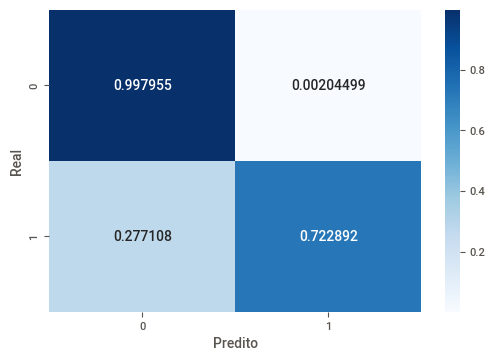

In [35]:
y_pred = grid_search.predict(X_test)

prec, rec, f1, n = precision_recall_fscore_support(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, normalize='true')

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

In [36]:
#f1
prec, rec, f1, n

(array([0.98020086, 0.96256684]),
 array([0.99795501, 0.72289157]),
 array([0.98899826, 0.82568807]),
 array([3423,  249]))

In [37]:
grid_search.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', RandomForestClassifier(max_depth=5, n_estimators=50))])

#### Feature importance

<AxesSubplot:>

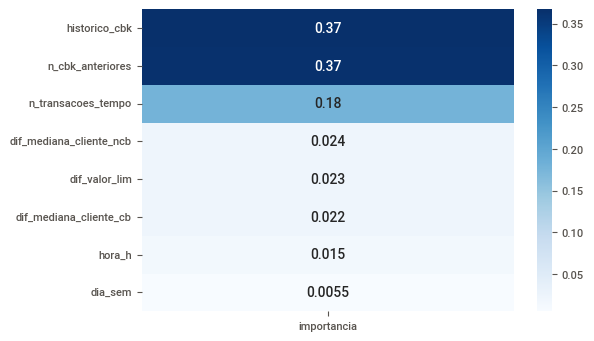

In [38]:
best_model = grid_search.best_estimator_.named_steps['clf']
imp = best_model.feature_importances_

feature_importances = pd.DataFrame(
    imp,
    index = X_train.columns,
    columns=['importancia']).sort_values('importancia', ascending=False)

sns.heatmap(feature_importances, cmap='Blues', annot=True)

#### Análise de erros

In [39]:
erros = test[y_test != y_pred]
erros.head(5)

,CBK,hora_h,dia_sem,n_cbk_anteriores,historico_cbk,n_transacoes_tempo,dif_mediana_cliente_cb,dif_mediana_cliente_ncb,dif_valor_lim
7477,1,9,3,-1,-1,0,351.00,384.00,83.00
7500,1,11,3,-1,-1,0,-20.00,13.00,-288.00
7503,1,11,3,-1,-1,0,-77.00,-44.00,-345.00
7507,1,11,3,-1,-1,0,-31.52,1.48,-299.52
7563,1,14,3,-1,-1,0,-20.00,13.00,-288.00


In [40]:
# o modelo sofre mais com cartões que estão fazendo a sua primeira transação
erros[['CBK','historico_cbk']].value_counts()

CBK  historico_cbk
1    -1               66
0     1                6
1     0                3
0    -1                1
dtype: int64

#### Previsao CBK na base de submissao

In [41]:
submissao_ = submissao.drop(['Dia','Hora','Cartão','data_hora', 'semana_mes', 'Valor'], axis=1)

In [42]:
submissao_pred = grid_search.predict(submissao_)

In [43]:
submissao['pred'] = submissao_pred

In [44]:
submissao.pred.value_counts()

0    11796
1       24
Name: pred, dtype: int64

#### Conclusão

1) As features baseadas no CBK são as mais importantes para o modelo indicar a classe de uma transação seguida da feature que indica a quantidade de transações em um período de tempo;

2) Apesar de existir uma diferença significativa entre o valor de transferências CBK e não CBK, o modelo dá pouco peso às features relacionadas ao valor da transferência;

3) O modelo sofre mais com cartões que estão fazendo a sua primeira transação e precisa ser pensado de como evoluir nesse cenário;

4) O desempenho dele na base de submissão está atrelada à maneira como ele foi pensado para funcionar: assumi um cenário onde o modelo é executado em tempo real e, portanto, ele apenas tem acesso a dados do passado e também não tem acesso aos dados de CBK de registros de junho. Assim, em casos que o cartão utilizado na transferência não tem registro na nossa base, o modelo fica sem disposição das duas features que mais tem peso nas classificações dele e classificará a transferência com base quase que exclusivamente na quantidade de transferências em um determinado tempo. Por exemplo, se um cartão foi utilizado para fazer uma transferência n (n>1) vezes, é provável que o modelo entenda que as primeiras transferências não são CBK e só tenda a classificar como CBK as transferências que ocorrerem apenas a partir de um certo ponto. A atitude nesse cenário seria de classificar a sequência de transferências como um todo invés de transferências individualmente. Por conta desse comportamento, o número de 24 classes positivas na base de submissão parece ser uma subrepresentação do real desempenho do modelo.


### Proposta de regras de negócio

- Estabelecer limites de numero de transações em um período de tempo
- Limitar transações baseado na quantidade de vezes que o cartão já fez chargeback

In [45]:
def plot_cbk_ncbk(col):

    max_value = np.max(base[col])

    trans = []
    for value in range(max_value+1):
        cartoes = base[base[col] >= value].Cartão.drop_duplicates()
        per_trans = base[base.Cartão.isin(cartoes)].CBK.value_counts(normalize=True).reset_index(name='per_trans').rename({'index':'CBK'}, axis=1)
        per_trans[str(col)] = value
        trans.append(per_trans)
    trans = pd.concat(trans).reset_index(drop=True)

    sns.lineplot(data=trans, x=str(col), y='per_trans', hue='CBK')

#### Estabelecer limites de numero de transações em um período de tempo

Assumindo 3 transações, como exemplo

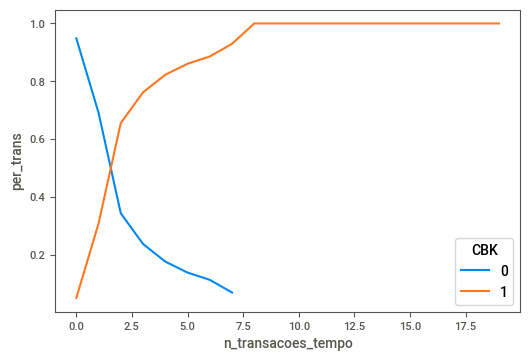

In [46]:
plot_cbk_ncbk('n_transacoes_tempo')

In [47]:
lim_trans_tempo = 3
base_block_trans_tempo = base[base.n_transacoes_tempo >= lim_trans_tempo]

valor_block_trans_tempo = base_block_trans_tempo.groupby('CBK').Valor.sum()

print('Assumindo limite de 2 transações num período de 1h, em maio, o impacto seria:')
print('Numero de transações a menos: ' + str(len(base_block_trans_tempo)))
print('Numero de transações CBK: ' + str(base_block_trans_tempo.CBK.value_counts().loc[1]))
print('Valor bloqueado que seria CBK: ' + str(valor_block_trans_tempo.loc[1]))
print('Valor bloqueado que não seria CBK: ' + str(valor_block_trans_tempo.loc[0]))

Assumindo limite de 2 transações num período de 1h, em maio, o impacto seria:
Numero de transações a menos: 193
Numero de transações CBK: 158
Valor bloqueado que seria CBK: 25550.57
Valor bloqueado que não seria CBK: 3361.5


#### Limitar transações baseado na quantidade de vezes que o cartão já fez chargeback

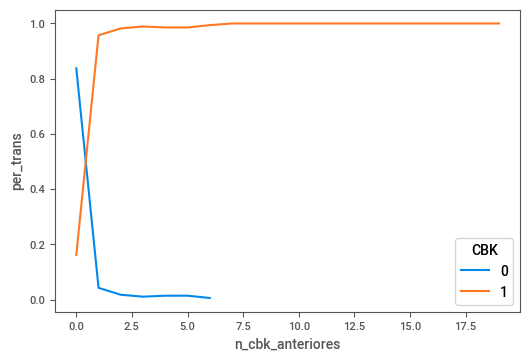

In [48]:
plot_cbk_ncbk('n_cbk_anteriores')

In [49]:
lim_trans_n_cbk_anterior = 1
base_block_n_cbk_anterior = base[base.n_cbk_anteriores >= lim_trans_n_cbk_anterior]
valor_block_n_cbk_anterior = base_block_n_cbk_anterior.groupby('CBK').Valor.sum()

print('Assumindo limite de 1 CBKs para o cartão, em maio, o impacto seria:')
print('Numero de transações a menos: ' + str(len(base_block_n_cbk_anterior)))
print('Numero de transações CBK: ' + str(base_block_n_cbk_anterior.CBK.value_counts().loc[1]))
print('Valor bloqueado que seria CBK: ' + str(valor_block_n_cbk_anterior.loc[1]))
print('Valor bloqueado que não seria CBK: ' + str(valor_block_n_cbk_anterior.loc[0]))

Assumindo limite de 1 CBKs para o cartão, em maio, o impacto seria:
Numero de transações a menos: 405
Numero de transações CBK: 387
Valor bloqueado que seria CBK: 67742.05
Valor bloqueado que não seria CBK: 2440.78


#### O impacto conjunto das duas regras em conjunto seria

In [50]:
base_block = pd.concat([base_block_trans_tempo, base_block_n_cbk_anterior]).drop_duplicates()
valor_base_block = base_block.groupby('CBK').Valor.sum()


print('Assumindo limite de 1 CBKs para o cartão e o limite de 2 transações em uma mesma hora, em maio, o impacto seria:')
print('Numero de transações a menos: ' + str(len(base_block)))
print('Numero de transações CBK: ' + str(base_block.CBK.value_counts().loc[1]))
print('Valor bloqueado que seria CBK: ' + str(valor_base_block.loc[1]))
print('Valor bloqueado que não seria CBK: ' + str(valor_base_block.loc[0]))

Assumindo limite de 1 CBKs para o cartão e o limite de 2 transações em uma mesma hora, em maio, o impacto seria:
Numero de transações a menos: 437
Numero de transações CBK: 387
Valor bloqueado que seria CBK: 67742.05
Valor bloqueado que não seria CBK: 5527.28


#### Conclusão

As duas regras de negócio tem muita interseção de casos devido transações que tiveram pedido de CBK no passado também tenderem a ser transações que acontecem seguidas vezes com o mesmo cartão em um curto período de tempo. Mesmo assim, ambas as regras podem ser utilizadas de forma isolada e faz sentido de coexistirem. 
Utilizar o limite de 1 CBK por cartão e de 2 transações em uma mesma hora teria economizado ao cliente o valor de 67742.05 reais em 387 CBKs ao custo de 5527.28 reais por não ter efetuado 50 transações que não resultaram em CBK.